In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import random
import argparse
from tqdm import tqdm
import librosa
from torchvision.models import densenet121
from torchvision.models import mobilenet_v2
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
!nvidia-smi

Fri Aug  2 10:54:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:08:00.0  On |                  N/A |
|  0%   46C    P8              42W / 250W |   1584MiB / 24576MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
N_FFT = 256
HOP_LEN = 256 // 6
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [4]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [5]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [6]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [7]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.78s


In [8]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [9]:
print(data_train.shape)

X_train, X_valid, y_train, y_valid = train_test_split(data_train, data_train_labels, stratify = data_train_labels, test_size = TEST_SPLIT_RATIO, random_state = SEED)   
X_test, y_test = data_test, data_test_labels


(10316, 4000)


In [10]:
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(7737, 2579, 2580, 7737, 2579, 2580)

In [11]:
# balance
y_train.sum(), len(y_train) - y_train.sum()

(3869, 3868)

In [12]:
y_valid.sum(), len(y_valid) - y_valid.sum()

(1289, 1290)

In [13]:
y_test.sum(), len(y_test) - y_test.sum()

(1290, 1290)

In [14]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

In [15]:
test = np.arange(20)
print(test.shape, test)
test_out = random_data_shift(test)
print(test_out.shape,test_out)

(20,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,) [18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [16]:
class AugmentedSTFTDataset(Dataset):
    def __init__(self, inputs, targets, n_fft, hop_length, augment=False):
        self.inputs = inputs
        self.targets = targets
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        
        if self.augment:
            sample = random_data_shift(sample)
            
        data = librosa.stft(sample, n_fft=self.n_fft, hop_length=self.hop_length)
        data = librosa.amplitude_to_db(np.abs(data), ref=np.max)
        data = np.flipud(data)  # Flip vertically
        data = data.copy()  
        data = np.expand_dims(data, axis=-1)  # Add channel dimension
        data = np.transpose(data, (2, 0, 1))  # Reorder dimensions to match PyTorch expectations
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, n_fft, hop_length, shuffle=True, augment=False):
    dataset = AugmentedSTFTDataset(inputs, targets, n_fft, hop_length, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [17]:
train_loader = create_dataloader(X_train, y_train, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=True, augment=AUGM)
valid_loader = create_dataloader(X_valid, y_valid, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 


In [18]:
EVAL_FREQ = len(train_loader)//EVAL_FREQ

In [19]:
print(len(train_loader), EVAL_FREQ)

242 60


In [20]:
for x, y in train_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


In [21]:
for x, y in valid_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


# Model

In [22]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = mobilenet_v2(weights=None).features
        self.model[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(1280, 1))
        
    def forward(self, x):
        out = self.model.forward(x)
        out = torch.nn.functional.avg_pool2d(out, kernel_size = out.shape[2:], stride= out.shape[2:], padding=0, count_include_pad = False)
        out = self.classifier(out.view(out.shape[0], -1))
        return out

In [23]:
model = MobileNetV2()
#model.to(device)

# Utilities

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation

## Accuracies and losses



In [26]:
epoch_df = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{0}.csv",sep=";")
epoch_df = epoch_df.drop_duplicates(subset=['epoch'], keep='first')
epoch_df = epoch_df.drop(["valid_loss","valid_acc"], axis=1)
epoch_df["epoch"] = epoch_df["epoch"].astype(str)
df_new = epoch_df.set_index("epoch")
for i in range(5):
    df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_valid = df_valid.rename(columns={"valid_loss":f"valid_loss_{i}","valid_acc":f"valid_acc_{i}"})
    df_valid["epoch"] = df_valid["epoch"].astype(str)
    df_valid = df_valid.drop_duplicates(subset=['epoch'], keep='first')
    df_valid = df_valid.set_index("epoch")
    df_new = df_new.join(df_valid)


In [27]:
df_new = df_new.reset_index()
df_new["epoch"] = df_new["epoch"].astype(float)

df_new["valid_loss_max"]=df_new[[f"valid_loss_{i}" for i in range(5)]].max(axis=1)
df_new["valid_loss_min"]=df_new[[f"valid_loss_{i}" for i in range(5)]].min(axis=1)
df_new["valid_loss_mean"]=df_new[[f"valid_loss_{i}" for i in range(5)]].mean(axis=1)

df_new["valid_acc_max"]=df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=1)
df_new["valid_acc_min"]=df_new[[f"valid_acc_{i}" for i in range(5)]].min(axis=1)
df_new["valid_acc_mean"]=df_new[[f"valid_acc_{i}" for i in range(5)]].mean(axis=1)

In [28]:
df_new

,epoch,valid_loss_0,valid_acc_0,valid_loss_1,valid_acc_1,valid_loss_2,valid_acc_2,valid_loss_3,valid_acc_3,valid_loss_4,valid_acc_4,valid_loss_max,valid_loss_min,valid_loss_mean,valid_acc_max,valid_acc_min,valid_acc_mean
0,0.247934,0.693243,50.019387,0.692729,54.400931,0.692884,50.019387,0.697265,50.019387,0.701427,49.980613,0.701427,0.692729,0.695510,54.400931,49.980613,50.887941
1,0.495868,0.692878,51.454052,0.692607,50.019387,0.692737,50.019387,0.693019,50.290810,0.692709,50.019387,0.693019,0.692607,0.692790,51.454052,50.019387,50.360605
2,0.743802,0.693932,49.980613,0.692940,50.019387,0.692394,55.486623,0.693111,49.980613,0.693861,50.019387,0.693932,0.692394,0.693248,55.486623,49.980613,51.097325
3,0.991736,0.693051,49.980613,0.693545,49.980613,0.692176,49.980613,0.694084,50.019387,0.691914,50.019387,0.694084,0.691914,0.692954,50.019387,49.980613,49.996123
4,1.000000,0.692851,49.980613,0.693179,49.980613,0.692025,59.170221,0.694843,50.019387,0.691829,50.058162,0.694843,0.691829,0.692945,59.170221,49.980613,51.841799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.247934,0.840127,79.565723,0.667056,82.939124,0.735026,80.457542,0.687718,82.590151,0.660769,82.628926,0.840127,0.660769,0.718139,82.939124,79.565723,81.636293
96,19.495868,0.846017,79.333075,0.674208,82.900349,0.739912,80.379992,0.685939,82.435052,0.665736,82.628926,0.846017,0.665736,0.722362,82.900349,79.333075,81.535479
97,19.743802,0.857117,78.984102,0.681867,83.016673,0.748470,80.651415,0.691395,82.473827,0.673568,82.706475,0.857117,0.673568,0.730483,83.016673,78.984102,81.566499
98,19.991736,0.869765,79.100427,0.689109,83.055448,0.754841,80.728965,0.698032,82.512602,0.679770,82.706475,0.869765,0.679770,0.738303,83.055448,79.100427,81.620783


In [29]:
EPOCHS = np.max(df_new["epoch"].values).astype(int)
epochs_train = np.arange(1,EPOCHS+1)
df_new_train = pd.DataFrame({"epoch":epochs_train})
df_new_train = df_new_train.set_index("epoch")

for i in range(5):
    df_train = pd.read_csv(f"{TRAIN_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_train = df_train.rename(columns={"train_loss":f"train_loss_{i}","train_acc":f"train_acc_{i}"})
    
    df_train = df_train.set_index("epoch")
    df_new_train = df_new_train.join(df_train)

df_new_train["train_loss_max"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_loss_min"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_loss_mean"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].mean(axis=1)

df_new_train["train_acc_max"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_acc_min"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_acc_mean"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].mean(axis=1)
df_new_train = df_new_train.reset_index()

In [30]:
df_new_train

,epoch,train_loss_0,train_acc_0,train_loss_1,train_acc_1,train_loss_2,train_acc_2,train_loss_3,train_acc_3,train_loss_4,train_acc_4,train_loss_max,train_loss_min,train_loss_mean,train_acc_max,train_acc_min,train_acc_mean
0,1,0.692596,50.006462,0.693129,50.006462,0.692040,58.924648,0.694901,49.993538,0.691828,50.071087,0.694901,0.691828,0.692899,58.924648,49.993538,51.800439
1,2,0.558443,71.099910,0.528971,76.851493,0.486555,78.014734,0.685554,58.472276,0.569059,68.282280,0.685554,0.486555,0.565717,78.014734,58.472276,70.544139
2,3,0.446012,78.505881,0.455955,80.082719,0.441404,79.087502,0.708119,65.503425,0.415768,80.961613,0.708119,0.415768,0.493452,80.961613,65.503425,76.828228
3,4,0.430031,79.022877,0.421611,81.413985,0.403280,82.409203,0.428091,80.199044,0.387907,82.241179,0.430031,0.387907,0.414184,82.409203,79.022877,81.057257
4,5,0.413144,81.969756,0.352989,84.050666,0.383441,83.171772,0.402486,81.866356,0.356631,84.373788,0.413144,0.352989,0.381738,84.373788,81.866356,83.086468
5,6,0.344388,84.903709,0.333126,85.459480,0.384434,84.490112,0.397763,81.401060,0.311699,87.113868,0.397763,0.311699,0.354282,87.113868,81.401060,84.673646
6,7,0.346039,85.278532,0.275409,88.419284,0.339394,85.937702,0.288719,88.483908,0.257004,88.535608,0.346039,0.257004,0.301313,88.535608,85.278532,87.331007
7,8,0.303091,88.600233,0.215090,91.508337,0.296076,86.829520,0.243772,90.086597,0.232399,90.719917,0.303091,0.215090,0.258086,91.508337,86.829520,89.548921
8,9,0.316721,86.558097,0.207977,91.508337,0.252559,90.034897,0.191748,92.477705,0.205221,91.081815,0.316721,0.191748,0.234845,92.477705,86.558097,90.332170
9,10,0.244477,89.841024,0.163469,94.132093,0.205266,91.805609,0.168836,93.628021,0.147613,94.287191,0.244477,0.147613,0.185932,94.287191,89.841024,92.738788


In [31]:
SMALL_SIZE = 15
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

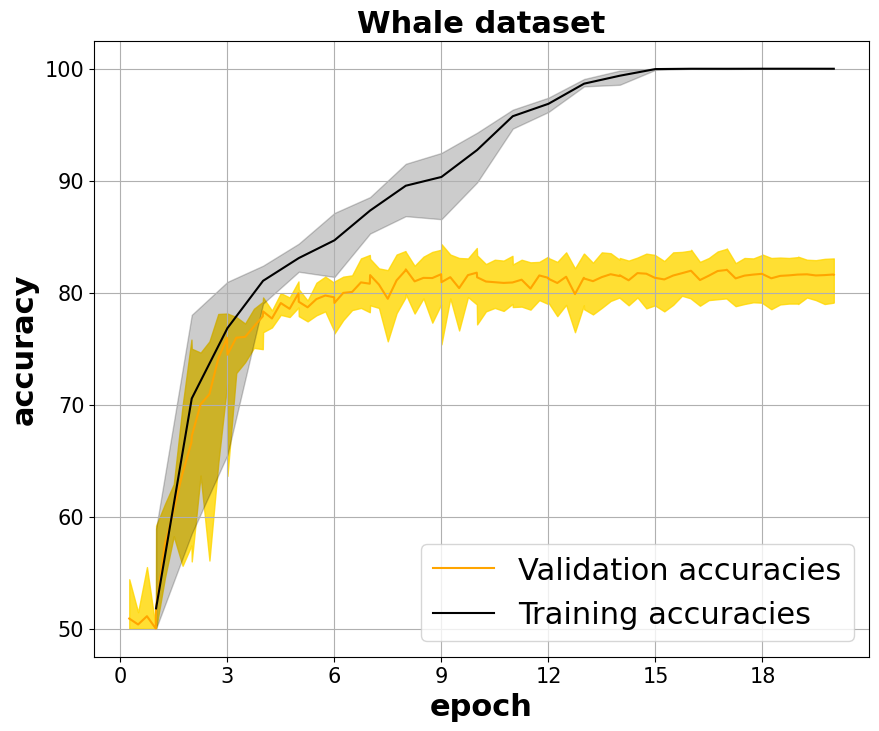

In [32]:
# Accuracies
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_acc_mean"], 'orange',label="Validation accuracies")
ax.fill_between(df_new["epoch"], df_new["valid_acc_min"],df_new["valid_acc_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_acc_mean"], 'k-',label="Training accuracies")
ax.fill_between(df_new_train["epoch"], df_new_train["train_acc_min"],df_new_train["train_acc_max"], color='k', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("accuracy",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('mobilenet_accuracies.svg', format='svg')


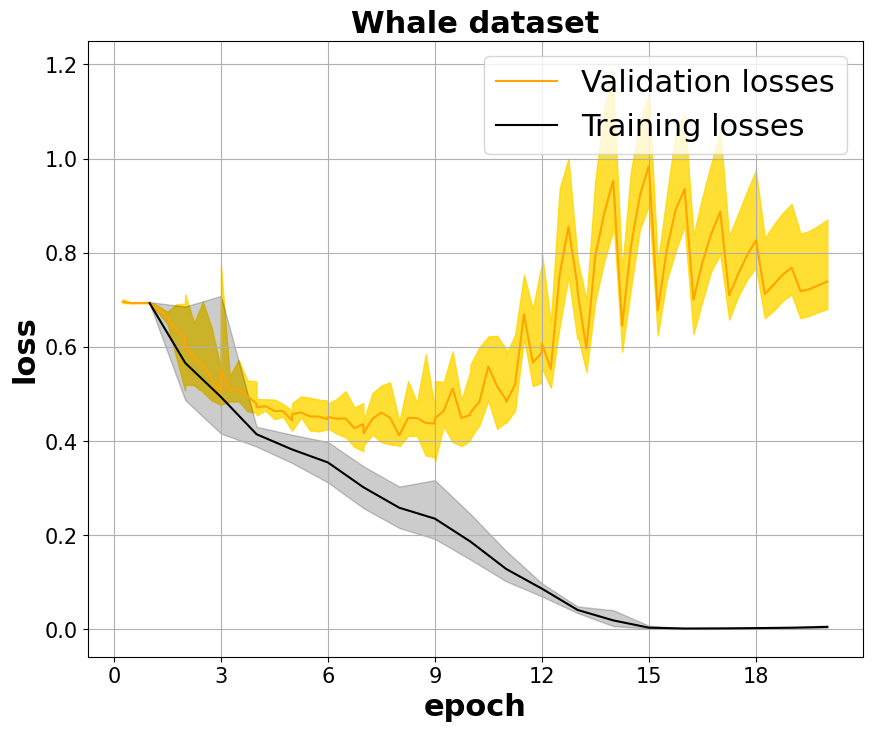

In [33]:
# Losses
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_loss_mean"], 'orange',label="Validation losses")
ax.fill_between(df_new["epoch"], df_new["valid_loss_min"],df_new["valid_loss_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_loss_mean"], 'k-',label="Training losses")
ax.fill_between(df_new_train["epoch"], df_new_train["train_loss_min"],df_new_train["train_loss_max"], color='k', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("loss",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('mobilenet_losses.svg', format='svg')

## The best model

In [34]:
# The model with the best validation accuracy
IND = np.argmax(df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=0).values)
IND

1

In [35]:
state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{IND}.pt")

In [36]:
model = MobileNetV2()

In [37]:
model.load_state_dict(state_dict)
model.to(device)
print(f"Number of the parameters: {count_parameters(model)}\n")
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)

train_loss, train_acc = evaluate(model, train_loader, criterion, device)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(160*"-"+"\n")
print(f"The model with the best validation accuracy:")
print(f'Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t\n')

Number of the parameters: 2224577

----------------------------------------------------------------------------------------------------------------------------------------------------------------

The model with the best validation accuracy:
Train Loss: 0.208 -  Train Acc: 91.51% | Valid Loss: 0.357 - Valid Acc: 84.34% | Test Loss: 0.362 - Test Acc: 83.99% 	



In [38]:
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_true.append(y.view(-1,1))

        x = x.to(device)
        y = y.to(device)
                
        y_pred = model(x)
            
        top_pred = (torch.sigmoid(y_pred) > 0.5).int()
        y_preds.append(top_pred.detach().cpu().view(-1,1))

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)
results = classification_report(y_true, y_preds, target_names=target_names,output_dict=True)
print(pd.DataFrame(results).T,"\n")

              precision    recall  f1-score      support
no-whale       0.808586  0.890698  0.847658  1290.000000
whale          0.878343  0.789147  0.831360  1290.000000
accuracy       0.839922  0.839922  0.839922     0.839922
macro avg      0.843464  0.839922  0.839509  2580.000000
weighted avg   0.843464  0.839922  0.839509  2580.000000 



In [39]:
# Recall accuracy 
recall_score(y_true,y_preds)

0.7891472868217054

## Confusion matrix

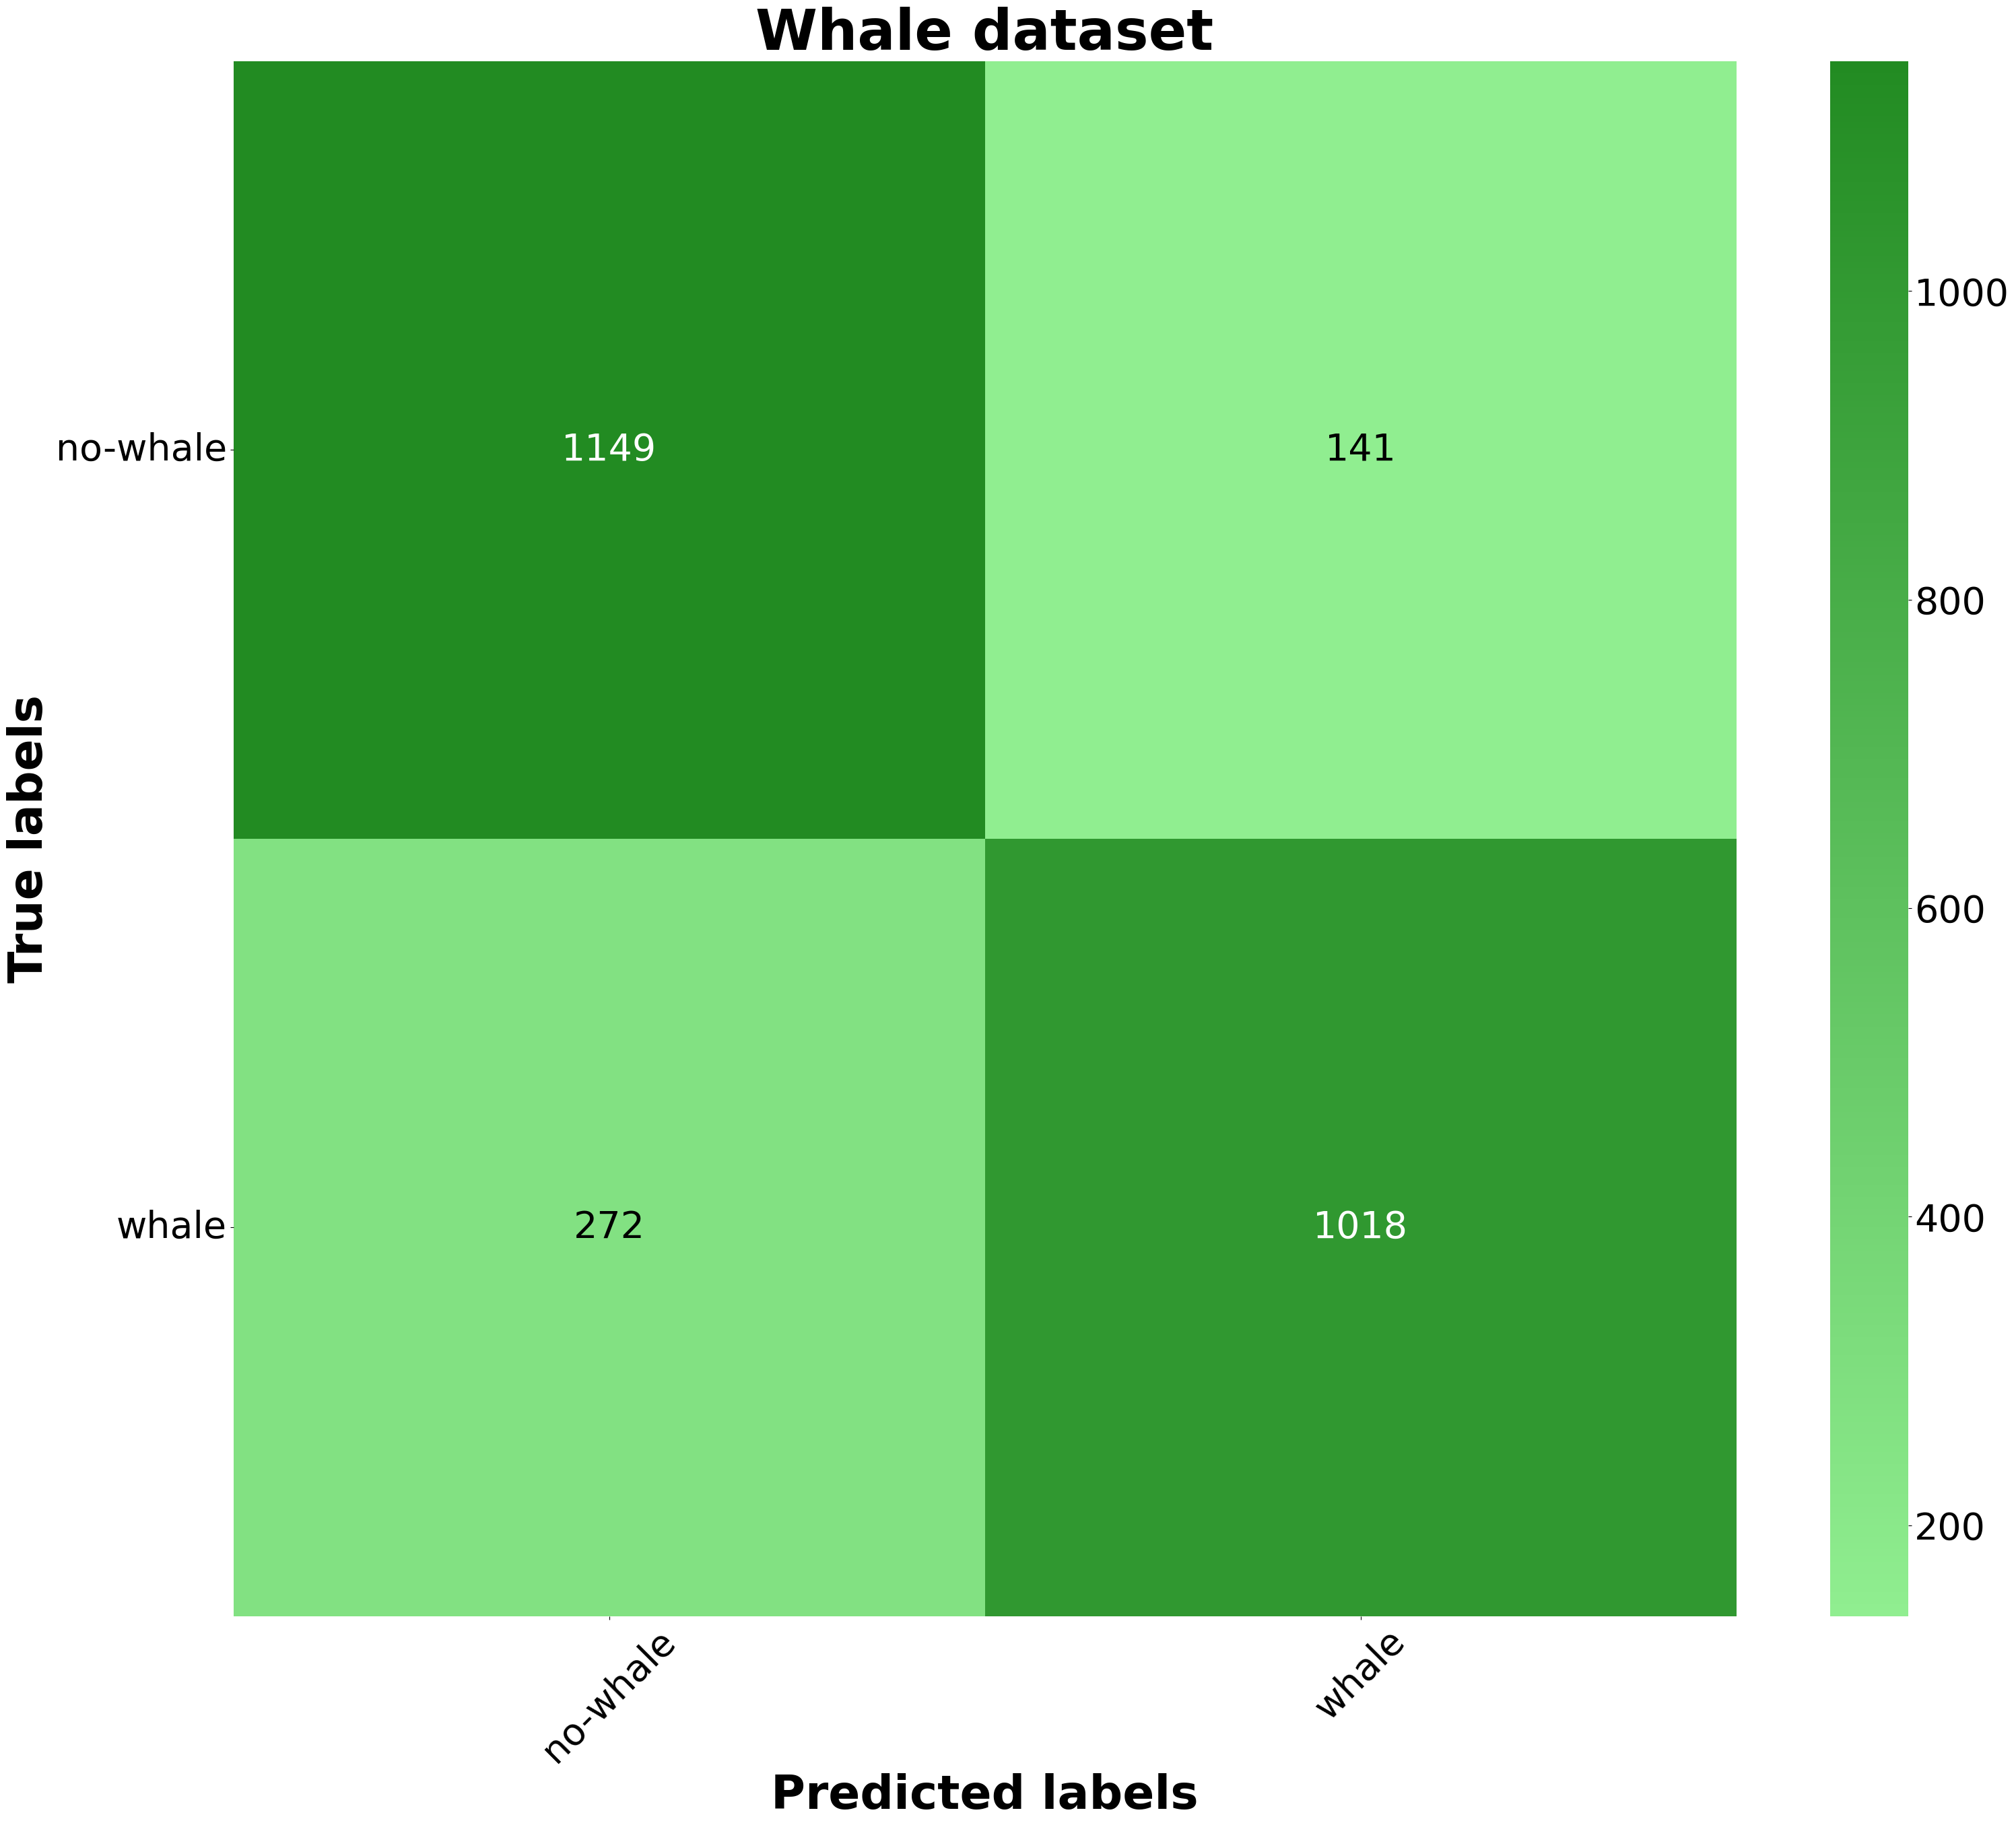

In [40]:
cm = confusion_matrix(y_true, y_preds, labels=list(range(len(target_names))))

# Adjust font sizes and styles
SMALL_SIZE = 50
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title is effectively disabled
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize is effectively disabled
plt.rc('figure', titlesize=0)  # fontsize of the figure title is effectively disabled

# Create a custom colormap from light green to forest green

light_to_forest_green_cmap = LinearSegmentedColormap.from_list("light_to_forest_green", ["lightgreen", "forestgreen"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
# Create the heatmap but without annotations
sns.heatmap(cm, cmap=light_to_forest_green_cmap, ax=ax)

# Manually add the annotations with specific color conditions
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Determine the color based on the condition
        color = 'white' if (i, j) not in [(0, 1), (1, 0)] else 'black'
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha="center", va="center", color=color, fontsize=MEDIUM_SIZE)

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title("Whale dataset", fontsize=60, weight="bold")

# Display the plot
plt.show()

# Save the figure
fig.savefig('mobilenet_cm.svg', format='svg')


## Accuracies among the 5 models

In [41]:
final_results = {"train_losses":[],
                 "train_accuracies":[],
                 "valid_losses":[],
                 "valid_accuracies":[],
                 "test_losses":[],
                 "test_accuracies":[],
                 "test_recalls":[]}

In [42]:
for ind in range(5):
    model = MobileNetV2()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{ind}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    final_results["train_losses"].append(train_loss)
    final_results["train_accuracies"].append(train_acc)
    
    final_results["valid_losses"].append(valid_loss)
    final_results["valid_accuracies"].append(valid_acc)
    
    final_results["test_losses"].append(test_loss)
    final_results["test_accuracies"].append(test_acc)

    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_true.append(y.view(-1,1))

            x = x.to(device)
            y = y.to(device)
                
            y_pred = model(x)
            
            top_pred = (torch.sigmoid(y_pred) > 0.5).int()
            y_preds.append(top_pred.detach().cpu().view(-1,1))

        y_preds = torch.cat(y_preds)
        y_true = torch.cat(y_true)
    test_recall = recall_score(y_true,y_preds)
    
    final_results["test_recalls"].append(test_recall)
    
    print(f'Model {ind} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')

Model 0 | Train Loss: 0.303 -  Train Acc: 88.60% | Valid Loss: 0.440 - Valid Acc: 79.88% | Test Loss: 0.428 - Test Acc: 81.24% 	
Model 1 | Train Loss: 0.208 -  Train Acc: 91.51% | Valid Loss: 0.357 - Valid Acc: 84.34% | Test Loss: 0.362 - Test Acc: 83.99% 	
Model 2 | Train Loss: 0.291 -  Train Acc: 87.31% | Valid Loss: 0.419 - Valid Acc: 81.58% | Test Loss: 0.429 - Test Acc: 81.28% 	
Model 3 | Train Loss: 0.004 -  Train Acc: 99.95% | Valid Loss: 0.868 - Valid Acc: 83.48% | Test Loss: 0.903 - Test Acc: 82.52% 	
Model 4 | Train Loss: 0.154 -  Train Acc: 94.61% | Valid Loss: 0.400 - Valid Acc: 83.56% | Test Loss: 0.413 - Test Acc: 82.25% 	


In [43]:
print(f"Mean test accuracy: {np.mean(final_results['test_accuracies']):.4f}")
print(f"Mean test recall: {np.mean(final_results['test_recalls']):.4f}")

Mean test accuracy: 0.8226
Mean test recall: 0.7898
